In [49]:
import base64
import datetime
import json
import os
import random
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image
from sklearn import preprocessing

np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

# Load the Data

In [50]:
d = pd.read_json('tmp/raw_data.json')
d.index.name = 'id'
d = d[['manager_id']]
print len(d)

124011


In [51]:
d.dtypes

manager_id    object
dtype: object

In [52]:
d.manager_id.head()

id
0       b1b1852c416d78d7765d746cb1b8921f
1       d0b5648017832b2427eeb9956d966a14
10      5ba989232d0489da1b5f2c45f6688adc
100     9ca6f3baa475c37a3b3521a394d65467
1000    0b9d5db96db8472d7aeb67c67338c4d2
Name: manager_id, dtype: object

In [53]:
d.manager_id.value_counts().head(5)

e6472c7237327dd3903b3d6f6a94515a    6387
6e5c10246156ae5bdcd9b487ca99d96a    1683
8f5a9c893f6d602f4953fcc0b8e6e9b4    1011
cb87dadbca78fad02b388dc9e8f25a5b     971
62b685cc0d876c3a1a51d63a0d6a8082     956
Name: manager_id, dtype: int64

# Number of Apartments at the Same Manager

In [54]:
manager_ids = d.manager_id.unique().tolist()

In [55]:
vc = d.manager_id.value_counts()
d['num_apts_at_manager'] = np.nan
for mid in manager_ids:
    d.loc[d.manager_id == mid, 'num_apts_at_manager'] = vc[mid]

# Number of Apartments at the Same Manager Bucket

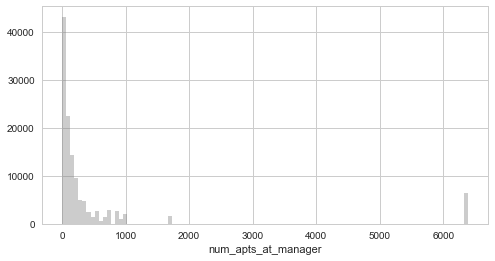

In [56]:
plt.figure(figsize=(8, 4))
ax = sns.distplot(a=d.num_apts_at_manager.dropna(), color='grey', kde=False, bins=100)

In [57]:
d.num_apts_at_manager.quantile([(0.1 * i) for i in range(1, 10)])

0.1     15.0
0.2     33.0
0.3     54.0
0.4     79.0
0.5    113.0
0.6    171.0
0.7    239.0
0.8    391.0
0.9    853.0
Name: num_apts_at_manager, dtype: float64

In [58]:
noise = np.random.randn(len(d))
d['num_apts_at_manager_q10'] = pd.qcut(d.num_apts_at_manager + 0.1*noise, 10, [0.1 * i for i in range(0, 10)])
d['num_apts_at_manager_q100'] = pd.qcut(d.num_apts_at_manager + 0.1*noise, 100, [0.01 * i for i in range(0, 100)])

# Private Manager

In [59]:
d['private_manager'] = 0.0
d.loc[d.num_apts_at_manager == 1.0, 'private_manager'] = 1.0

# Encode manager_id

In [60]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(d.manager_id.values))
d.loc[:, 'manager_code'] = lbl.transform(list(d.manager_id.values))
d.head()

,manager_id,num_apts_at_manager,num_apts_at_manager_q10,num_apts_at_manager_q100,private_manager,manager_code
id,,,,,,
0,b1b1852c416d78d7765d746cb1b8921f,62.0,0.3,0.33,0.0,3076
1,d0b5648017832b2427eeb9956d966a14,26.0,0.1,0.16,0.0,3593
10,5ba989232d0489da1b5f2c45f6688adc,235.0,0.6,0.69,0.0,1568
100,9ca6f3baa475c37a3b3521a394d65467,5.0,0.0,0.03,0.0,2677
1000,0b9d5db96db8472d7aeb67c67338c4d2,178.0,0.6,0.61,0.0,201


# Manager skill 

Inspired by: https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/improve-perfomances-using-manager-features

UPDATE: this will lead to horrible overfitting 
:(

In [61]:

# raw_data = pd.read_json('tmp/raw_data.json')
# train = raw_data[raw_data.interest_level.notnull()]
# temp = pd.concat([train.manager_id, pd.get_dummies(train.interest_level)], axis = 1).groupby('manager_id').mean()
# temp.columns = ['high_frac','low_frac', 'medium_frac']
# temp['count'] = train.groupby('manager_id').count().iloc[:,1]

# # compute skill
# temp['manager_skill'] = temp['high_frac']*2 + temp['medium_frac']

# d = d.merge(temp[['manager_skill']], left_on= 'manager_id', right_index=True, how='left')
# d.head()

# Save the Data

In [62]:
d.to_csv('tmp/features_manager_id.csv')